# Интеллектуальный анализ работы хранилища данных на основании обработки логов "Ростелеком"

In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('log_week_end.csv')
data.rename(columns={'query': 'q'}, inplace=True)

In [3]:
data.sample(5)

,rn,loguser,q
43079,898654,etl_528,from tbl_50065
621445,654191,etl_1151,"into tbl_21349,join tbl_21349"
305707,975167,dev_1136,from tbl_212291
539382,664335,etl_2048,from tbl_211222
499136,608215,dev_1586,into tbl_211513


In [4]:
data_copy = data.copy()

## Определение метрики "бесполезности" таблицы

In [5]:
data.q = data.q.str.lower().str.split(',')

In [6]:
# cобираем в списки все команды
intos, froms, joins = [], [], []

for x in data.q:
    for g in x:
        if 'join' in g:
            joins.append(g)
        if 'into' in g:
            intos.append(g)
            
for x in data[data.loguser.str.contains('dev')].q:
    for g in x:
        if 'from' in g:
            froms.append(g)

In [7]:
# оставляем только название таблиц
intos_tbs = [re.search('tbl_\d*', x).group(0) for x in intos]
froms_tbs = [re.search('tbl_\d*', x).group(0) for x in froms]
joins_tbs = [re.search('tbl_\d*', x).group(0) for x in joins]

In [8]:
# функция для датафрейма
def create_df(input_data, column):
    df = pd.DataFrame(data = input_data, columns=['col']).groupby('col').agg({'col': 'count'})
    df.columns= [column]
    df.reset_index(inplace=True)
    return df

In [9]:
# делаем датафрейм с количество from (from только от пользователей dev) при помощи функции `create_df`
df1 = create_df(froms_tbs, 'count_froms')

In [10]:
# делаем датафрейм с кол-ом join
df3 = create_df(joins_tbs, 'count_joins')

In [11]:
# функция для объединения
def merge_df(data1, data2):
    data = data1.merge(data2, on ='col', how='outer')
    data = data.fillna(0)
    return data

In [12]:
# объединим join и from при помощи merge_df
df1 = merge_df(df1,df3)

In [13]:
# датафрейм с кол-ом into
df2 = create_df(intos_tbs, 'count_intos')
df = merge_df(df1,df2)
df.count_intos = df.count_intos + 1
# определяем метрику "бесполезности" 
df['useless'] = df['count_intos'] / df['count_froms']
df.fillna(0, inplace=True)

In [14]:
#включаем опцию, где inf (бесконечность) считаем как NaN
pd.set_option('mode.use_inf_as_na', True) 

In [15]:
# ТОП-10 "бесполезных таблиц"
df.sort_values(by = 'useless', ascending = False, inplace = True)
df.head(10)

,col,count_froms,count_joins,count_intos,useless
1463,tbl_211513,8.0,1.0,9594.0,1199.250000
1692,tbl_29455,1.0,1595.0,471.0,471.000000
1636,tbl_26776,1.0,3083.0,469.0,469.000000
1644,tbl_27182,1.0,8208.0,465.0,465.000000
1462,tbl_211512,21.0,0.0,3139.0,149.476190
652,tbl_15647,2.0,0.0,203.0,101.500000
1919,tbl_44933,10.0,0.0,881.0,88.100000
1520,tbl_23594,1.0,0.0,54.0,54.000000
1466,tbl_211522,32.0,0.0,1171.0,36.593750
1548,tbl_23770,12.0,0.0,325.0,27.083333


## Распределение пользователей по кол-ву запросов

In [16]:
# сгруппируем по пользователям
data_users = data.groupby('loguser').agg({'rn':'nunique'}).sort_values('rn', ascending=False).reset_index()
data_users= data_users.rename(columns={'rn':'count_rn'})

In [17]:
# разделим пользователей
etl_users = data_users[data_users['loguser'].str.startswith('etl')]
dev_users = data_users[data_users['loguser'].str.startswith('dev')]

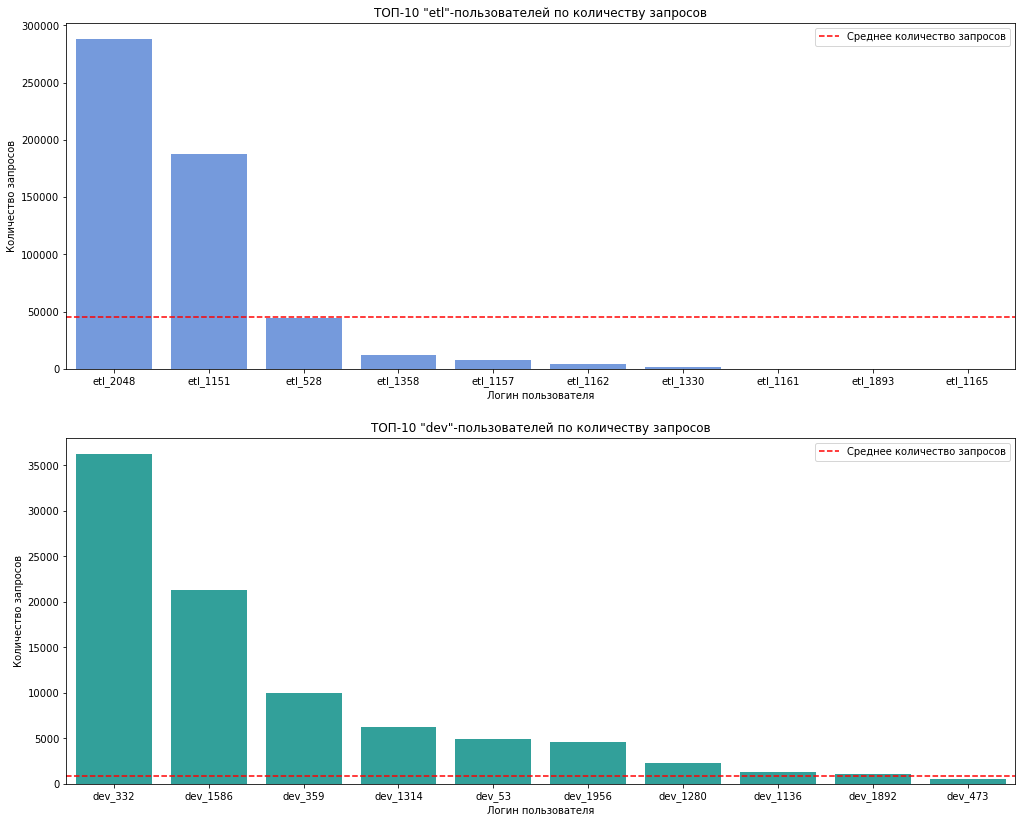

In [18]:
# TОП-10 кол-ва запросов для etl/dev
plt.figure(figsize=(17, 14)) 

ax1 = plt.subplot(2, 1, 1)
ax1 = sns.barplot(data = etl_users.head(10), x = 'loguser', y = 'count_rn', color = 'cornflowerblue')
ax1.set_title('ТОП-10 "etl"-пользователей по количеству запросов')
ax1.set_xlabel('Логин пользователя')
ax1.set_ylabel('Количество запросов')
plt.axhline(y=etl_users['count_rn'].mean(), label = 'Среднее количество запросов', color ="red", linestyle ="--")
plt.legend()

ax2 = plt.subplot(2, 1, 2)
ax2 = sns.barplot(data = dev_users.head(10), x = 'loguser', y = 'count_rn', color = 'lightseagreen')
ax2.set_title('ТОП-10 "dev"-пользователей по количеству запросов')
ax2.set_xlabel('Логин пользователя')
ax2.set_ylabel('Количество запросов')
plt.axhline(y=dev_users['count_rn'].mean(), label = 'Среднее количество запросов', color ="red", linestyle ="--")
plt.legend()
plt.show()

## Распределение по количеству действий в запросе

In [19]:
# разделим значения в запросах по запятой и сгруппируем по пользователю
data_copy['count_q'] = data_copy['q'].apply(lambda x: x.split(","))
data_count_q = data_copy.explode('count_q')
df_exp = data_count_q.copy()
data_count_q = data_count_q.groupby('loguser').agg({'count_q':'count'}).sort_values('count_q', ascending=False).reset_index()

In [20]:
# разделим пользователей
etl_count_q = data_count_q[data_count_q['loguser'].str.startswith('etl')]
dev_count_q = data_count_q[data_count_q['loguser'].str.startswith('dev')]

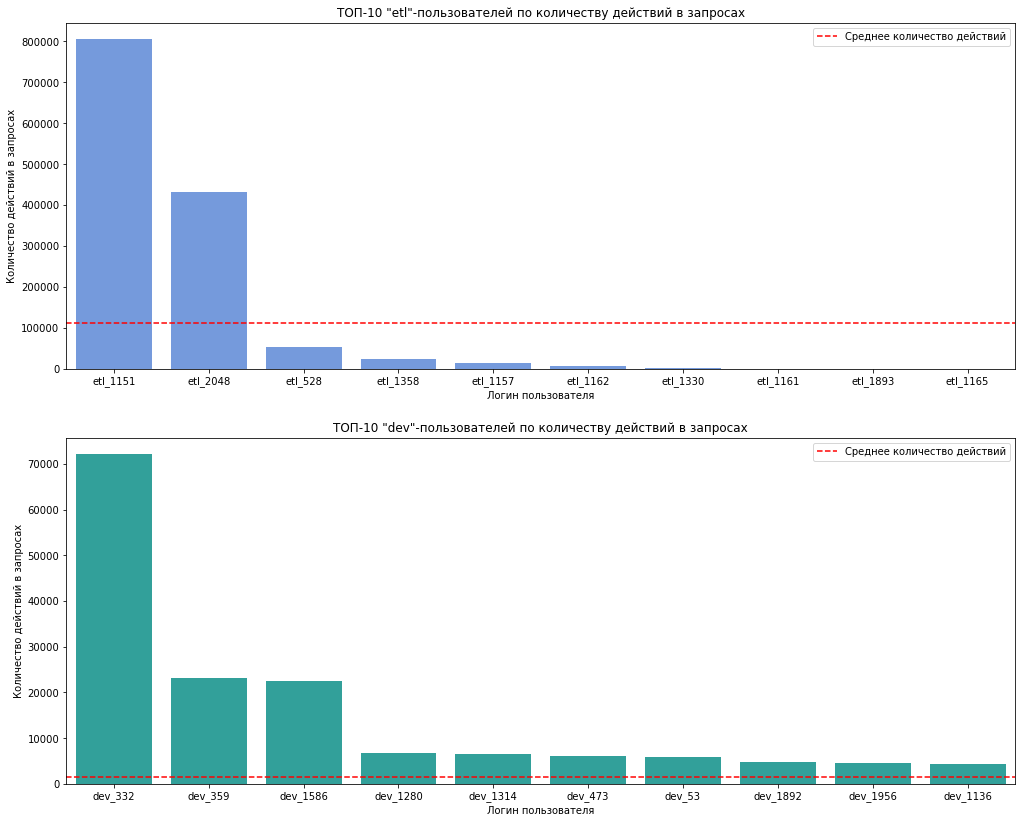

In [21]:
#TОП-10 кол-ва действий в запросах для etl/dev
plt.figure(figsize=(17, 14)) #TОП-10 кол-ва действий для etl/dev

ax1 = plt.subplot(2, 1, 1)
ax1 = sns.barplot(data = etl_count_q.head(10), x = 'loguser', y = 'count_q', color = 'cornflowerblue')
ax1.set_title('ТОП-10 "etl"-пользователей по количеству действий в запросах')
ax1.set_xlabel('Логин пользователя')
ax1.set_ylabel('Количество действий в запросах')
plt.axhline(y=etl_count_q['count_q'].mean(), label = 'Среднее количество действий', color ="red", linestyle ="--")
plt.legend()

ax2 = plt.subplot(2, 1, 2)
ax2 = sns.barplot(data = dev_count_q.head(10), x = 'loguser', y = 'count_q', color = 'lightseagreen')
ax2.set_title('ТОП-10 "dev"-пользователей по количеству действий в запросах')
ax2.set_xlabel('Логин пользователя')
ax2.set_ylabel('Количество действий в запросах')
plt.axhline(y=dev_count_q['count_q'].mean(), label = 'Среднее количество действий', color ="red", linestyle ="--")
plt.legend()
plt.show()

## Датафрейм - пользователь/таблица/кол-во действий в запросе

In [22]:
# датафрейм для определения кол-ва действий в запросе пользователя к таблице 
df_exp = df_exp.groupby(['loguser','count_q']).agg({'count_q':'count'}).rename(columns={'count_q':'q'})
df_exp = df_exp.reset_index()
df_exp['tab'] = [re.search('tbl_\d*', x).group(0) for x in df_exp['count_q']]
df_exp = df_exp[['loguser', 'q', 'tab']]
df_exp = df_exp.rename(columns={'q':'count'}).sort_values('count', ascending=False)

In [23]:
# ТОП-10 таблиц по кол-ву действий в запросе
df_exp.head(10)

,loguser,count,tab
2690,dev_332,27247,tbl_7207
2611,dev_332,27242,tbl_11022
60963,etl_1358,11262,tbl_33595
60958,etl_1358,11256,tbl_33623
1272,dev_1586,9593,tbl_211513
55826,etl_1151,7743,tbl_27182
54660,etl_1151,7038,tbl_20007
52212,etl_1151,7038,tbl_14714
59926,etl_1157,4144,tbl_33595
59725,etl_1157,4144,tbl_33623
